In [2]:
import pandas as pd
import numpy as np

def engineer_features(df):
    # 1. Garage-related
    df["GarageScore"] = df["GarageCars"] * df["GarageArea"]
    df["GarageAgeDiff"] = df["YrSold"] - df["GarageYrBlt"]
    df["GarageAgeDiff"] = df["GarageAgeDiff"].replace({np.nan: -1})
    df["GarageStyleCombo"] = df["GarageType"].fillna("None") + "_" + \
                             df["GarageFinish"].fillna("None") + "_" + \
                             df["GarageQual"].fillna("None") + "_" + \
                             df["GarageCond"].fillna("None")

    # 2. Bathroom combination
    df["TotalBath"] = (
        df["FullBath"] + 0.5 * df["HalfBath"] +
        df["BsmtFullBath"] + 0.5 * df["BsmtHalfBath"]
    )

    # 3. House age and remodel
    df["HouseAge"] = df["YrSold"] - df["YearBuilt"]
    df["RemodelAge"] = df["YrSold"] - df["YearRemodAdd"]
    df["IsRemodeled"] = (df["YearBuilt"] != df["YearRemodAdd"]).astype(int)

    # 4. Total square footage
    df["TotalSqFeet"] = df["GrLivArea"] + df["TotalBsmtSF"]

    # 5. Porch square footage
    df["TotalPorchSF"] = (
        df["OpenPorchSF"] + df["EnclosedPorch"] +
        df["3SsnPorch"] + df["ScreenPorch"]
    )

    # 6. Overall score
    df["OverallScore"] = df["OverallQual"] * df["OverallCond"]

    # 7. Total floors and rooms
    df["TotalFloors"] = df["1stFlrSF"] + df["2ndFlrSF"]
    df["TotalRooms"] = df["TotRmsAbvGrd"] + df["BedroomAbvGr"]

    return df


In [3]:
import pandas as pd

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")


In [4]:
train = engineer_features(train)
test = engineer_features(test)


In [5]:
from sklearn.preprocessing import MinMaxScaler

def clean_and_encode(train, test):
    # SalePrice hedef değişkeni ayrılıyor
    y = train["SalePrice"]
    train = train.drop("SalePrice", axis=1)

    # Yeni feature engineering uygulanıyor
    train = engineer_features(train)
    test = engineer_features(test)

    # Train ve test birleşiyor
    all_data = pd.concat([train, test], axis=0)

    # Kullanıcının işaretlediği + otomatik belirlenen kategorik sayısallar
    pseudo_categoricals = [
        'OverallQual', 'GarageCars', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces',
        'HalfBath', 'RsmtCullBath', 'BedroomAbvGr', 'KitchenAbvGr',
        'MSSubClass', 'OverallCond', 'BsmtFullBath', 'BsmtHalfBath',
        'PoolArea', 'MoSold', 'YrSold'
    ]

    none_fill = [
        'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
        'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
        'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
        'MasVnrType'
    ]
    for col in none_fill:
        if col in all_data.columns:
            all_data[col] = all_data[col].fillna("None")

    zero_fill = [
        'GarageYrBlt', 'GarageArea', 'GarageCars',
        'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
        'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea'
    ]
    for col in zero_fill:
        if col in all_data.columns:
            all_data[col] = all_data[col].fillna(0)

    # LotFrontage gruba göre dolduruluyor
    if "LotFrontage" in all_data.columns and "Neighborhood" in all_data.columns:
        all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
            lambda x: x.fillna(x.median())
        )

    # Mod ile doldurulacaklar
    mode_fill = ['MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Functional']
    for col in mode_fill:
        if col in all_data.columns:
            all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

    # Kalan eksikler ortalama ile
    all_data = all_data.fillna(all_data.mean(numeric_only=True))

    # Gereksiz kolon
    all_data = all_data.drop(columns=['Utilities'], errors='ignore')

    # Pseudo-kategorikleri string yap
    for col in pseudo_categoricals:
        if col in all_data.columns:
            all_data[col] = all_data[col].astype(str)

    # One-hot encoding
    all_data = pd.get_dummies(all_data)

    # MinMaxScaler ile normalizasyon
    scaler = MinMaxScaler()
    all_data_scaled = pd.DataFrame(
        scaler.fit_transform(all_data),
        columns=all_data.columns,
        index=all_data.index
    )

    # Geri ayır
    X_clean = all_data_scaled.iloc[:len(y)].copy()
    X_test_clean = all_data_scaled.iloc[len(y):].copy()

    return X_clean, X_test_clean, y


In [6]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

X_clean, X_test_clean, y_clean = clean_and_encode(train, test)

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_log_error
from xgboost import XGBRegressor
import optuna
import pandas as pd
import numpy as np

# Veriyi yükle ve temizle
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
X_clean, X_test_clean, y_clean = clean_and_encode(train, test)

# Hedef değişkeni logaritmik hale getir
y_log = np.log1p(y_clean)

# Optuna objective fonksiyonu
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 6),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
    }

    model = XGBRegressor(**params, random_state=42)
    scores = cross_val_score(model, X_clean, y_log, scoring="neg_mean_squared_log_error", cv=5)
    mean_rmsle = np.sqrt(-scores.mean())
    return mean_rmsle

# Optuna çalışmasını başlat
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)


c:\Users\alper\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-06-19 12:53:18,738] A new study created in memory with name: no-name-1a8dce26-68d5-4129-8443-2b82b9464fff
[I 2025-06-19 12:53:29,781] Trial 0 finished with value: 0.01391209576481814 and parameters: {'n_estimators': 590, 'learning_rate': 0.23558513211349952, 'max_depth': 3, 'subsample': 0.7728960975626787, 'colsample_bytree': 0.8033754122491102, 'gamma': 3.879433709351707}. Best is trial 0 with value: 0.01391209576481814.
[I 2025-06-19 12:53:35,968] Trial 1 finished with value: 0.012394704946546625 and parameters: {'n_estimators': 288, 'learning_rate': 0.24433225934537747, 'max_depth': 6, 'subsample': 0.883929041111399, 'colsample_bytree': 0.8858466917117295, 'gamma': 1.8603458697234798}. Best is trial 1 

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split


In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split

def check_data_leakage(X, y, train_df=None, test_df=None):
    results = {}

    # 1. Korelasyon Analizi
    print("🔍 1. Korelasyon Analizi:")
    correlation = X.copy()
    correlation["SalePrice"] = y
    corr = correlation.corr()["SalePrice"].sort_values(ascending=False)
    print(corr.head(15))
    results['top_corr'] = corr.head(15)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=corr.head(15).values, y=corr.head(15).index)
    plt.title("En Yüksek Korelasyonlu 15 Özellik")
    plt.xlabel("Korelasyon")
    plt.tight_layout()
    plt.show()

    # 2. Mutual Information
    print("\n🔍 2. Mutual Information (Bilgi Kazancı):")
    mi = mutual_info_regression(X, y)
    mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)
    print(mi_series.head(15))
    results['top_mi'] = mi_series.head(15)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=mi_series.head(15).values, y=mi_series.head(15).index)
    plt.title("Mutual Information'a Göre En Anlamlı 15 Özellik")
    plt.xlabel("Bilgi Kazancı")
    plt.tight_layout()
    plt.show()

    # 3. train-test overlap kontrolü
    if train_df is not None and test_df is not None:
        print("\n🔍 3. Train ve Test veri setinde ortak satır kontrolü:")
        common_cols = ['GrLivArea', 'TotalBsmtSF', 'YearBuilt']
        overlap = pd.merge(train_df, test_df, on=common_cols, how='inner')
        print(f"🔗 Ortak özelliklerle eşleşen satır sayısı: {len(overlap)}")
        results['overlap_count'] = len(overlap)
    else:
        print("ℹ️ Train ve test dataframe'leri verilmediği için overlap kontrolü atlandı.")

    return results


🔍 1. Korelasyon Analizi:
SalePrice           1.000000
TotalSqFeet         0.773277
TotalFloors         0.710275
GrLivArea           0.700927
TotalBath           0.673011
GarageScore         0.672054
GarageArea          0.650888
TotalBsmtSF         0.612134
OverallScore        0.606873
1stFlrSF            0.596981
YearBuilt           0.586570
YearRemodAdd        0.565608
Foundation_PConc    0.530840
GarageCars_3.0      0.527132
ExterQual_Gd        0.509675
Name: SalePrice, dtype: float64


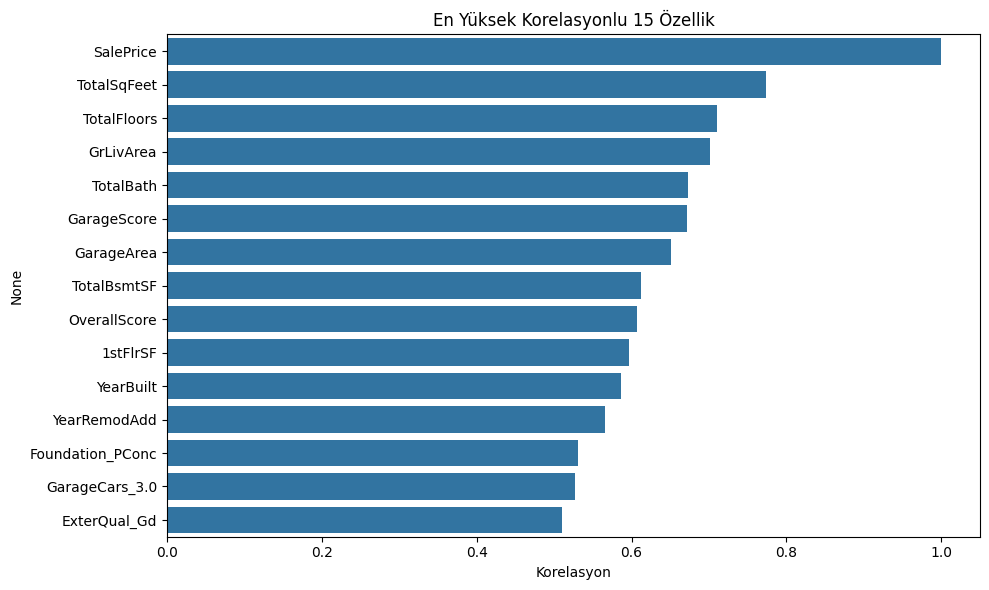


🔍 2. Mutual Information (Bilgi Kazancı):
TotalSqFeet      0.669379
TotalFloors      0.478441
GrLivArea        0.458767
OverallScore     0.447431
GarageScore      0.385729
GarageArea       0.363225
TotalBsmtSF      0.362352
YearBuilt        0.357453
TotalBath        0.340463
HouseAge         0.335846
1stFlrSF         0.299339
ExterQual_TA     0.269643
RemodelAge       0.256947
GarageYrBlt      0.255374
GarageAgeDiff    0.252189
dtype: float64


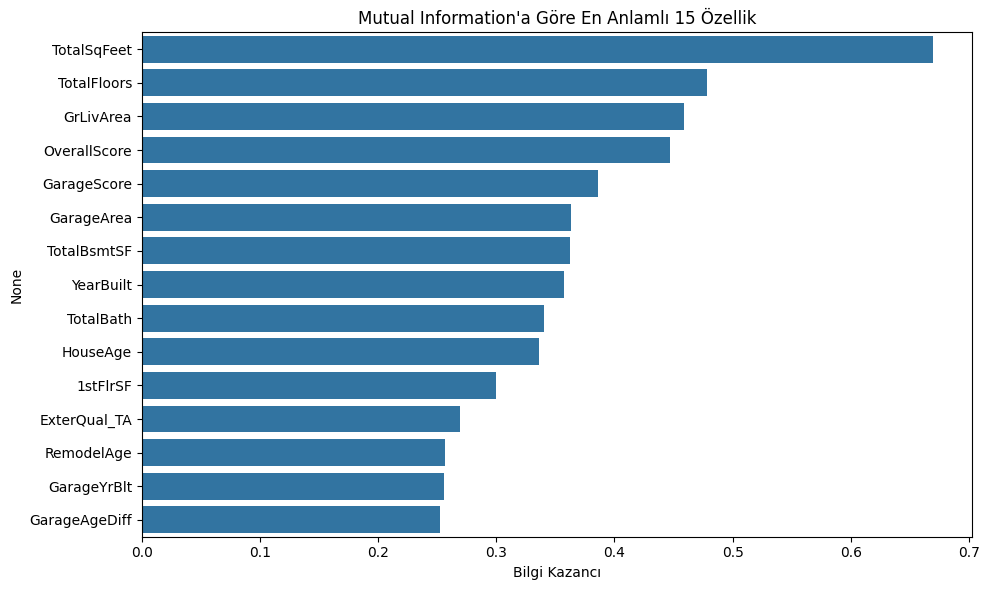


🔍 3. Train ve Test veri setinde ortak satır kontrolü:
🔗 Ortak özelliklerle eşleşen satır sayısı: 171


In [11]:
# X = Özellikler
# y = Hedef değişken (log uygulanmış olabilir)
# train ve test orijinal veri setleri (ID ve diğer tüm sütunlarla birlikte)

results = check_data_leakage(X_clean, y_log, train_df=train, test_df=test)


In [12]:
# Temel tanımlayıcı özelliklerle çakışan ev var mı?
intersection = pd.merge(
    train, test,
    on=["GrLivArea", "YearBuilt", "TotalBsmtSF"],
    how="inner"
)

print(f"Aynı özelliklere sahip ev sayısı (train & test): {len(intersection)}")


Aynı özelliklere sahip ev sayısı (train & test): 171


In [13]:
from sklearn.feature_selection import mutual_info_regression

info_scores = mutual_info_regression(X_clean, y_clean)
mi_df = pd.DataFrame({
    "Feature": X_clean.columns,
    "Mutual_Info": info_scores
}).sort_values(by="Mutual_Info", ascending=False)

print(mi_df.head(20))  # En yüksek bilgi kazancı verenler


            Feature  Mutual_Info
28      TotalSqFeet     0.663647
31      TotalFloors     0.495519
13        GrLivArea     0.481454
30     OverallScore     0.444849
22      GarageScore     0.392323
3         YearBuilt     0.367550
9       TotalBsmtSF     0.366515
15       GarageArea     0.365792
25         HouseAge     0.339278
24        TotalBath     0.339098
10         1stFlrSF     0.310084
23    GarageAgeDiff     0.291387
14      GarageYrBlt     0.258872
201    ExterQual_TA     0.258338
26       RemodelAge     0.254512
4      YearRemodAdd     0.243710
268      FullBath_1     0.240839
200    ExterQual_Gd     0.216429
269      FullBath_2     0.215503
290  KitchenQual_TA     0.212160


In [24]:
import pandas as pd

# Verileri yükle
train = pd.read_csv(train.csv)
test = pd.read_csv(test.csv)

# Ortak kolonları bul
common_columns = list(set(train.columns).intersection(set(test.columns)))

# Her iki veri setinden sadece ortak kolonları al
train_common = train[common_columns].copy()
test_common = test[common_columns].copy()

# Her satır için hash değeri alalım (tüm sütunlar dahil)
train_common['row_hash'] = train_common.astype(str).agg('-'.join, axis=1)
test_common['row_hash'] = test_common.astype(str).agg('-'.join, axis=1)

# Kesişen hash'ler
duplicate_hashes = set(train_common['row_hash']).intersection(set(test_common['row_hash']))

# Bu hash'lere sahip satırları çek
duplicate_train_rows = train_common[train_common['row_hash'].isin(duplicate_hashes)]
duplicate_test_rows = test_common[test_common['row_hash'].isin(duplicate_hashes)]

# Sonuçları birleştir
duplicate_rows = pd.concat([
    duplicate_train_rows.assign(Source='Train'),
    duplicate_test_rows.assign(Source='Test')
])

import ace_tools as tools; tools.display_dataframe_to_user(name="Tam Aynı Satırlar (Train & Test)", dataframe=duplicate_rows)


AttributeError: 'DataFrame' object has no attribute 'csv'